In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [186]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

from evaluation import Referee, load_data, select_dates

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data_dir = 'data/'
sub_dir = 'submissions_uncertainty/'
model_dir = 'models/uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.

data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv
data/prep/converted_sales_level_12.csv
data/prep/converted_sales_level_11.csv
data/prep/converted_sales_level_10.csv
data/prep/converted_sales_all.csv
data/prep/norm_level_11.csv
data/prep/.DS_Store
data/prep/norm_level_10.csv
data/prep/norm_level_12.csv
data/prep/norm_level_1.csv
data/prep/norm_level_2.csv
data/prep/norm_level_3.csv
data/prep/norm_level_7.csv
data/prep/norm_level_6.csv
data/prep/converted_sales_level_9.csv
data/prep/norm_level_4.csv
data/prep/norm_level_5.csv
data/prep/converted_sales_level_8.csv
data/prep/converted_sales_level_5.csv
data/prep/norm_level_8.csv
data/prep/norm_level_9.csv
data/prep/converted_sales_level_4.csv
data/prep/converted_sales_level_6.csv
data/prep/converted_sales_level_7.csv
data/prep/converted_sales_level_3.csv
data/prep/norm_all.csv
data/prep/converted_sales_leve

In [5]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Train MLP with Dense layers and PL

## Data preparation (or read saved result)
From `lightgbm-poisson-w-scaled-pinball-loss.ipynb`.  

Note: categorical features are converted on-the-fly to reduce memory usage. 

In [6]:
# import functions from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
from lightgbm_kernel import (reduce_mem_usage, read_data, encode_categorical, simple_fe, \
                            weight_calc, make_wrmsse, agg_series)

In [7]:
calendar, sell_prices, sales_train_val, submission = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [8]:
NUM_ITEMS = sales_train_val.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1   # 28

In [9]:
calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 94.01 Mb (78.9% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [10]:
nrows = 365 * 2 * NUM_ITEMS
nrows

22257700

In [11]:
sales_train_val = pd.melt(sales_train_val,
                          id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                          var_name = 'day', value_name = 'demand')
print('Melted sales train validation has {} rows and {} columns'.format(*sales_train_val.shape))

Melted sales train validation has 58327370 rows and 8 columns


In [12]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0


In [13]:
sales_train_val = sales_train_val.iloc[-nrows:,:]

In [14]:
# from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
# separate test dataframes
forecast_submission = pd.concat([submission.iloc[0:int(771120/2),:].iloc[-30490:,:],submission.iloc[int(771120/2):,:].iloc[-30490:,:]])
forecast_submission['id'] = forecast_submission['id'].str.replace('_.\...._','_')
forecast_submission.drop_duplicates(inplace=True)

# submission fileのidのvalidation部分と, ealuation部分の名前を取得
test1_rows = [row for row in forecast_submission['id'] if 'validation' in row]
test2_rows = [row for row in forecast_submission['id'] if 'evaluation' in row]

# submission fileのvalidation部分をtest1, ealuation部分をtest2として取得
test1 = forecast_submission[forecast_submission['id'].isin(test1_rows)]
test2 = forecast_submission[forecast_submission['id'].isin(test2_rows)]

# test1, test2の列名の"F_X"の箇所をd_XXX"の形式に変更
test1.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
test2.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

# test2のidの'_evaluation'を置換
#test1['id'] = test1['id'].str.replace('_validation','')
test2['id'] = test2['id'].str.replace('_evaluation','_validation')

# sales_train_valからidの詳細部分(itemやdepartmentなどのid)を重複なく一意に取得。
product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

# idをキーにして, idの詳細部分をtest1, test2に結合する.
test1 = test1.merge(product, how = 'left', on = 'id')
test2 = test2.merge(product, how = 'left', on = 'id')

# test1, test2をともにmelt処理する.（売上数量:demandは0）
test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

# validation部分と, evaluation部分がわかるようにpartという列を作り、 test1,test2のラベルを付ける。
sales_train_val['part'] = 'train'
test1['part'] = 'test1'
test2['part'] = 'test2'

# sales_train_valとtest1, test2の縦結合.
data = pd.concat([sales_train_val, test1, test2], axis = 0)

# memoryの開放
del test1, test2, sales_train_val, forecast_submission

# delete test2 for now(6/1以前は, validation部分のみ提出のため.)
data = data[data['part'] != 'test2']

gc.collect()

14

In [15]:
#calendarの結合
# drop some calendar features(不要な変数の削除:weekdayやwdayなどはdatetime変数から後ほど作成できる。)
calendar.drop(['weekday', 'wday', 'month', 'year'],
              inplace = True, axis = 1)

# notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

# memoryの開放
del  calendar
gc.collect()

#sell priceの結合
# get the sell price data (this feature should be very important)
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# memoryの開放
del  sell_prices
gc.collect()

Our final dataset to train has 22257700 rows and 18 columns


0

In [16]:
%%time
data = reduce_mem_usage(simple_fe(data, DAYS_PRED=DAYS_PRED))

Mem. usage decreased to 2356.15 Mb (46.4% reduction)


In [17]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [20]:
data.memory_usage()

Index                     178061600
id                        178061600
item_id                    44515400
dept_id                    22257700
cat_id                     22257700
store_id                   22257700
state_id                   22257700
demand                     44515400
part                      178061600
date                      178061600
wm_yr_wk                   44515400
event_name_1               44515400
event_type_1               44515400
event_name_2               44515400
event_type_2               44515400
snap_CA                    22257700
snap_TX                    22257700
snap_WI                    22257700
sell_price                 44515400
shift_t28                  44515400
shift_t29                  44515400
shift_t30                  44515400
rolling_std_t7             44515400
rolling_std_t30            44515400
rolling_std_t60            44515400
rolling_std_t90            44515400
rolling_std_t180           44515400
rolling_mean_t7            4

In [24]:
print("{:.2f} GB".format(data.memory_usage().sum() / 1024**3))

2.30 GB


### Save prepared dataset
Pickle chosen for its speed. See: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d. 
Feather and parquet both require additional libraries (pyarrow). 

In [37]:
data.dtypes

id                                object
item_id                            int16
dept_id                             int8
cat_id                              int8
store_id                            int8
state_id                            int8
demand                             int16
part                              object
date                      datetime64[ns]
wm_yr_wk                           int16
event_name_1                     float16
event_type_1                     float16
event_name_2                     float16
event_type_2                     float16
snap_CA                             int8
snap_TX                             int8
snap_WI                             int8
sell_price                       float16
shift_t28                        float16
shift_t29                        float16
shift_t30                        float16
rolling_std_t7                   float16
rolling_std_t30                  float16
rolling_std_t60                  float16
rolling_std_t90 

In [39]:
fn = os.environ['DATA_DIR'] + 'prep/simple_fe_{}_{}.pickle'.format(
    data.date.min().date().strftime("%Y_%m_%d"), data.date.max().date().strftime("%Y_%m_%d")
)
print("Saving to file..")
data.to_pickle(fn)
print("Finished.")

Saving to file..
Finished.


### Read prepared dataset

In [ ]:
fn = 'simple_fe_2014_04_26_2016_04_24.pickle'
data = pd.read_pickle(fn)

In [154]:
features = [
#     "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend"
]

In [155]:
data.head()[features]

,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,...,week,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend
0,3,1,0,0,NaN,NaN,NaN,NaN,0,0,...,17,26,5,0,0,0,0,0,0,1
1,3,1,0,0,NaN,NaN,NaN,NaN,0,0,...,17,26,5,0,0,0,0,0,0,1
2,3,1,0,0,NaN,NaN,NaN,NaN,0,0,...,17,26,5,0,0,0,0,0,0,1
3,3,1,0,0,NaN,NaN,NaN,NaN,0,0,...,17,26,5,0,0,0,0,0,0,1
4,3,1,0,0,NaN,NaN,NaN,NaN,0,0,...,17,26,5,0,0,0,0,0,0,1


In [156]:
categorical_features = [
#     "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
]

In [157]:
for col in categorical_features:
    data[col] = data[col].astype('category')

In [158]:
print("{:.2f} GB".format(data.memory_usage().sum() / 1024**3))

2.82 GB


In [100]:
data.isna().sum() / data.index.size

id                        0.000000
item_id                   0.000000
dept_id                   0.000000
cat_id                    0.000000
store_id                  0.000000
state_id                  0.000000
demand                    0.000000
part                      0.000000
date                      0.000000
wm_yr_wk                  0.000000
event_name_1              0.921918
event_type_1              0.921918
event_name_2              0.998630
event_type_2              0.998630
snap_CA                   0.000000
snap_TX                   0.000000
snap_WI                   0.000000
sell_price                0.023433
shift_t28                 0.038356
shift_t29                 0.039726
shift_t30                 0.041096
rolling_std_t7            0.046575
rolling_std_t30           0.078082
rolling_std_t60           0.119178
rolling_std_t90           0.160274
rolling_std_t180          0.283562
rolling_mean_t7           0.046575
rolling_mean_t30          0.078082
rolling_mean_t60    

In [107]:
df = data.loc[list_IDs_temp, features]
df = pd.get_dummies(df, columns=categorical_features)#, dummy_na=True)
df = df.replace(np.nan, 0)
# df.drop(columns=['dayofweek_nan', 'day_nan'])
df

,snap_CA,snap_TX,snap_WI,sell_price,shift_t28,shift_t29,shift_t30,rolling_std_t7,rolling_std_t30,rolling_std_t60,...,day_29,day_30,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
23,0,0,0,8.976562,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
25,0,0,0,17.968750,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
27,0,0,0,7.980469,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
29,0,0,0,0.700195,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
31,0,0,0,0.580078,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
33,0,0,0,4.660156,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
35,0,0,0,1.120117,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
37,0,0,0,3.220703,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
39,0,0,0,12.968750,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
41,0,0,0,7.828125,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


## BatchCreator

In [166]:
class BatchCreator(Sequence):
    """Batch creator for M5 Uncertainty challenge.
    - batch_size: number of samples per batch. Note: if ensure_all_samples is True,
                  the final batch size may be smaller.
    - shuffle: whether to shuffle the samples.
    - ensure_all_samples: whether to ensure all samples are yielded. If False (default),
                          the batch size is always constant.
    - inp_shape: input shape of how a single sample enters the neural network. This is without the batch size.
    - categorical_features: which columns to convert to one-hot encoding
    """

    def __init__(self, df, features, labels, batch_size=128, shuffle=True, ensure_all_samples=False,
                 inp_shape=(3244,), out_shape=(9,), categorical_features=None):
        """Initialization"""
        # Save settings
        self.df = df
        self.list_IDs = self.df.index
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ensure_all_samples = ensure_all_samples
        self.inp_shape = inp_shape
        self.out_shape = out_shape
        self.categorical_features = categorical_features
        
        # initialize indices
        self.indexes = None
        self.on_epoch_end()

        # calculate properties
        self.n = self.df.index.size

    def __len__(self):
        """Denotes the number of batches per epoch"""
        if self.ensure_all_samples:
            return int(np.ceil(self.n / self.batch_size))
        return self.n // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = self.list_IDs[indexes]

        # Generate data
        x_batch, y_batch = self.__data_generation(list_IDs_temp)

        return x_batch, y_batch

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        
        # fill labels
        demand = self.df.loc[list_IDs_temp, 'demand'].values.astype(np.float32)
        y_batch = {'q%d'%d: demand for d in range(9)}

        # fill features
        x_batch = self.df.loc[list_IDs_temp, self.features]
        x_batch = pd.get_dummies(x_batch, columns=self.categorical_features)#, dummy_na=True)
        x_batch = x_batch.replace(np.nan, 0)
        x_batch = x_batch.values

        return x_batch, y_batch

    def flow(self, epochs=None):
        """returns a generator that will yield batches infinitely"""
        epochs_done = 0
        while True:
            for index in range(self.__len__()):
                batch_x, batch_y = self.__getitem__(index)
                yield batch_x, batch_y

            # track nr. of epochs
            epochs_done += 1
            if epochs is not None and epochs_done == epochs:
                break # stop yielding new elements

            # do on epoch end
            self.on_epoch_end()

Times to process validation set. 

**1.** Data selection (batch size 1024), only performing:
```
x_batch = self.df.loc[list_IDs_temp, self.features]
x_batch = x_batch.values
```

100%|██████████| 834/834 [00:51<00:00, 16.16it/s]  

**2.** Dummies. Adding:  
`x_batch = pd.get_dummies(x_batch, columns=self.categorical_features)`  

100%|██████████| 834/834 [01:20<00:00, 10.40it/s]

**3.** Total. Adding:  
`x_batch = x_batch.replace(np.nan, 0)`  

100%|██████████| 834/834 [01:25<00:00,  9.80it/s]

In [159]:
# going to evaluate with the last 28 days
train_df = data[data['date'] <= '2016-03-27']
val_df = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
test_df = data[(data['date'] > '2016-04-24')]

train_df.index.size, val_df.index.size, test_df.index.size

(21403980, 853720, 0)

In [167]:
labels = ['demand']
train_batch_creator = BatchCreator(train_df, features, labels, categorical_features=categorical_features)
val_batch_creator = BatchCreator(val_df, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=categorical_features)

## Initialize pinball loss

In [116]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [117]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

## Logger

In [151]:
class Logger(Callback):
    def __init__(self, val_batch_creator, update_plot=True):
        super().__init__()
        self.val_batch_creator = val_batch_creator
        self.update_plot = update_plot

        # training metrics
        self.losses = []
        # validation metrics
        self.val_x = []
        self.val_spl = []
        self.val_losses = []
        # save best model properties
        self.best_spl = np.inf
        self.best_model = None
        self.best_epoch = 0

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        if 'val_loss' in logs.keys():
            self.val_losses.append(logs.get('val_loss'))
        if self.update_plot and len(self.losses) % 100 == 0:
            self.plot()

    def on_epoch_end(self, batch, logs={}):
        # spl = self.validate()
        spl = 0
        # self.val_spl.append(spl)
        self.val_x.append(len(self.losses))

        if spl < self.best_spl:
            self.best_spl = spl
            self.best_model = self.model.get_weights()
            self.best_epoch = len(self.val_spl)
        if self.update_plot:
            self.plot()

    def validate(self):
        pass

    def plot(self, clear=True):
        if clear:
            clear_output()

        # plot losses
        N = len(self.losses)
        f, axes = plt.subplots(1, 2, figsize=(18, 6))
        ax = axes[0]
        ax.plot(range(0, N), self.losses, label='Train')
        if len(self.val_losses):
            ax.plot(self.val_losses, label='Validation')
        ax.set_xlabel("Step")
        ax.set_xlabel(r"$WSPL'$")
        ax.set_title("Loss")

        # plot WSPL
        ax = axes[1]
#         ax.plot(self.val_x, self.val_aucs, label='Validation AUC')
#         ax.plot(self.val_x, self.val_accuracies, label='Validation accuracy')
#         if len(self.accuracies):
#             ax.plot(self.accuracies, label="Train accuracy")
#         ax.set_ylim(0.5, 1)
        ax.set_xlabel("Epoch")
        ax.set_xlabel("Accuracy / AUC")
        ax.set_title("Model performance")

        for ax in axes:
            ax.legend()

        plt.show()

In [168]:
logger = Logger(val_batch_creator)

## Build model

In [182]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coef):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        return tensor1 + sigma_coef * tensor2

    return custom_layer

def get_model(inp_shape):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(64)(x)
    x = Dense(64)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)
    out_q1 = Dense(1, name="q1")(x)
    out_q2 = Dense(1, name="q2")(x)
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)
    
    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

def get_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(64)(x)
    x = Dense(64)(x)
    x = Dense(64)(x)
    
    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma
    
    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [164]:
model = get_dist_model(inp_shape=(195,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 195)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           12544       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

No handles with labels found to put in legend.


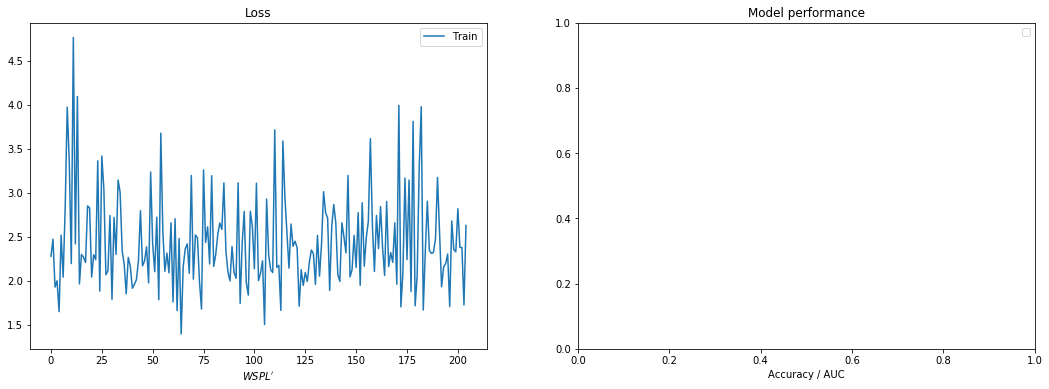

   206/167218 [..............................] - ETA: 58:48:50 - loss: 2.4323 - q0_loss: 0.0170 - q1_loss: 0.0645 - q2_loss: 0.2378 - q3_loss: 0.3183 - q4_loss: 0.5237 - q5_loss: 0.5140 - q6_loss: 0.4449 - q7_loss: 0.1962 - q8_loss: 0.1159

KeyboardInterrupt: 

In [169]:
history = model.fit(train_batch_creator.flow(), epochs=3,
                    steps_per_epoch=train_batch_creator.__len__(),
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

#### Increase batch size

In [171]:
labels = ['demand']
batch_size = 2500
train_batch_creator = BatchCreator(train_df, features, labels, categorical_features=categorical_features,
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(val_df, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=categorical_features, batch_size=batch_size)

No handles with labels found to put in legend.


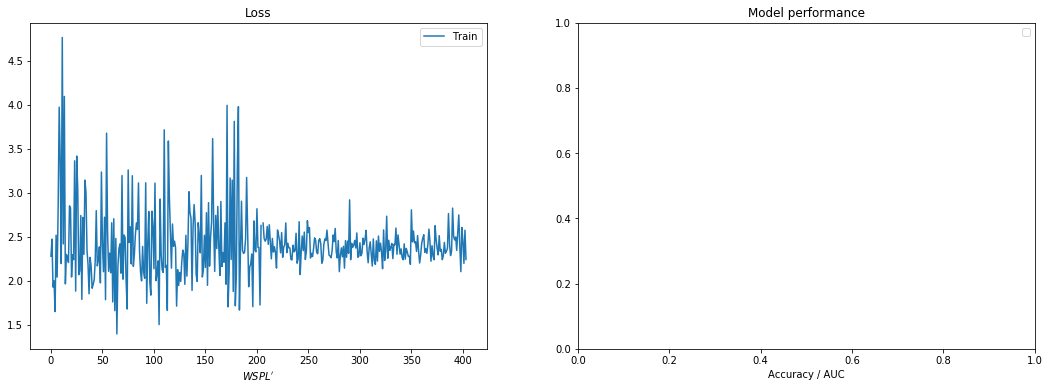

 199/8561 [..............................] - ETA: 3:13:01 - loss: 2.3904 - q0_loss: 0.0161 - q1_loss: 0.0617 - q2_loss: 0.2255 - q3_loss: 0.3010 - q4_loss: 0.5218 - q5_loss: 0.5097 - q6_loss: 0.4414 - q7_loss: 0.1961 - q8_loss: 0.1171

KeyboardInterrupt: 

In [172]:
history = model.fit(train_batch_creator.flow(), epochs=3,
                    steps_per_epoch=train_batch_creator.__len__(),
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

#### Further increase batch size

In [173]:
labels = ['demand']
batch_size = 25000
train_batch_creator = BatchCreator(train_df, features, labels, categorical_features=categorical_features,
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(val_df, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=categorical_features, batch_size=batch_size)

No handles with labels found to put in legend.


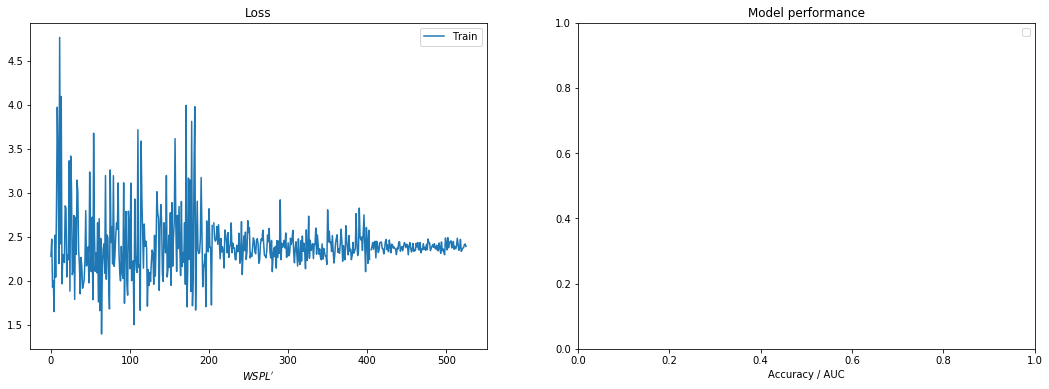

122/856 [===>..........................] - ETA: 18:36 - loss: 2.3838 - q0_loss: 0.0161 - q1_loss: 0.0615 - q2_loss: 0.2249 - q3_loss: 0.2987 - q4_loss: 0.5228 - q5_loss: 0.5092 - q6_loss: 0.4406 - q7_loss: 0.1946 - q8_loss: 0.1155

KeyboardInterrupt: 

In [174]:
history = model.fit(train_batch_creator.flow(), epochs=3,
                    steps_per_epoch=train_batch_creator.__len__(),
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

In [175]:
y_pred = model.predict(val_batch_creator.flow(epochs=1))

In [181]:
y_pred[0]

array([[-1.974117 ],
       [-0.6981909],
       [-0.8181995],
       ...,
       [-2.190229 ],
       [-3.0493588],
       [-3.8131104]], dtype=float32)

## Dense ipv DistLayer

In [183]:
model = get_model(inp_shape=(195,))
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 195)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           12544       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [184]:
logger_dense = Logger(val_batch_creator)

No handles with labels found to put in legend.


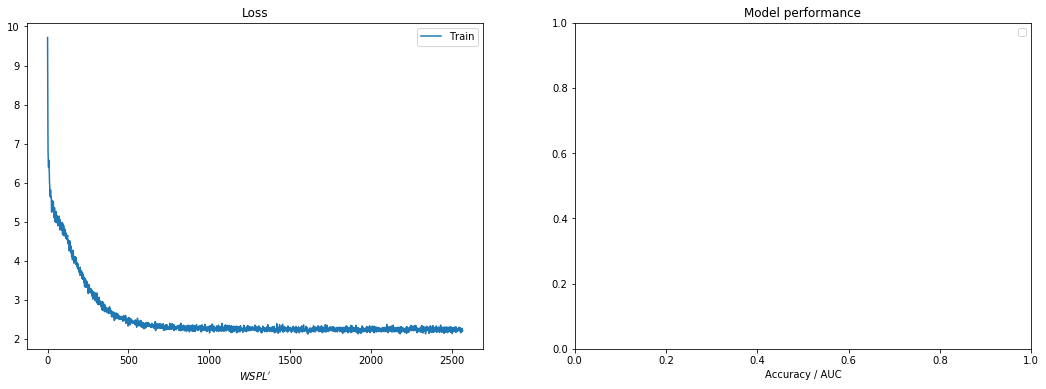

856/856 [==============================] - 1232s 1s/step - loss: 2.2375 - q0_loss: 0.0078 - q1_loss: 0.0316 - q2_loss: 0.2052 - q3_loss: 0.3108 - q4_loss: 0.4958 - q5_loss: 0.5019 - q6_loss: 0.4417 - q7_loss: 0.1717 - q8_loss: 0.0711 - val_loss: 2.2387 - val_q0_loss: 0.0083 - val_q1_loss: 0.0350 - val_q2_loss: 0.2283 - val_q3_loss: 0.3440 - val_q4_loss: 0.5079 - val_q5_loss: 0.4926 - val_q6_loss: 0.4234 - val_q7_loss: 0.1463 - val_q8_loss: 0.0529


In [185]:
history = model.fit(train_batch_creator.flow(), epochs=3,
                    steps_per_epoch=train_batch_creator.__len__(),
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger_dense])

In [187]:
model.save(model_dir + 'dense_model_1_ep.h5')

In [247]:
%%time
y_pred = model.predict(val_batch_creator.flow(epochs=1))

In [189]:
y_pred

[array([[-0.2829267 ],
        [-0.29479834],
        [-0.2900968 ],
        ...,
        [-0.27785304],
        [-0.26266697],
        [-0.25124982]], dtype=float32),
 array([[-0.00685988],
        [-0.00858353],
        [-0.00593702],
        ...,
        [-0.00447522],
        [ 0.00029732],
        [ 0.00351049]], dtype=float32),
 array([[ 0.01209697],
        [-0.00419804],
        [ 0.00197193],
        ...,
        [ 0.01882324],
        [ 0.03929672],
        [ 0.05474386]], dtype=float32),
 array([[ 0.02413359],
        [-0.04799209],
        [-0.04083584],
        ...,
        [ 0.03699293],
        [ 0.10126533],
        [ 0.15367737]], dtype=float32),
 array([[ 0.5916183 ],
        [-0.03989244],
        [ 0.07260334],
        ...,
        [ 0.74603724],
        [ 1.3739483 ],
        [ 1.8723199 ]], dtype=float32),
 array([[1.2669289 ],
        [0.20675808],
        [0.37875193],
        ...,
        [1.5120149 ],
        [2.5440938 ],
        [3.367398  ]], dtype=float32)

In [252]:
%%time
df = val_df
# from lightgbm-poisson-w-scaled-pinball-loss.ipynb
ids = df['id'].unique()
day_start = np.datetime64(df.date.min().date())
day_end = np.datetime64(df.date.max().date())
num_days = (day_end - day_start + 1).astype(int)

y_pred_df_list = []

for i, q in enumerate(quantiles):
    y_pred_df = pd.DataFrame.from_dict({
        'id': np.repeat(ids, num_days),
        'date': np.tile(np.arange(day_start, day_end+1),30490),
        'pred': y_pred[i].squeeze(),
        'demand': df['demand'],
    })
    
    y_pred_df['quantile'] = "{:.3f}".format(q)
    y_pred_df['item_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
    y_pred_df['dept_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
    y_pred_df['cat_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
    y_pred_df['store_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
    y_pred_df['state_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:4]))
    
    y_pred_df_list.append(y_pred_df)

CPU times: user 19 s, sys: 1.14 s, total: 20.1 s
Wall time: 20.2 s


In [253]:
y_pred_df = pd.concat(y_pred_df_list)
y_pred_df.head(13)

,id,date,pred,demand,quantile,item_id,dept_id,cat_id,store_id,state_id
21403980,HOBBIES_1_001_CA_1_validation,2016-03-28,-0.282927,1,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403981,HOBBIES_1_001_CA_1_validation,2016-03-29,-0.294798,1,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403982,HOBBIES_1_001_CA_1_validation,2016-03-30,-0.290097,0,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403983,HOBBIES_1_001_CA_1_validation,2016-03-31,-0.259075,0,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403984,HOBBIES_1_001_CA_1_validation,2016-04-01,-0.275724,1,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403985,HOBBIES_1_001_CA_1_validation,2016-04-02,-0.295717,0,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403986,HOBBIES_1_001_CA_1_validation,2016-04-03,-0.292554,1,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403987,HOBBIES_1_001_CA_1_validation,2016-04-04,-0.137994,0,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403988,HOBBIES_1_001_CA_1_validation,2016-04-05,-0.292433,0,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
21403989,HOBBIES_1_001_CA_1_validation,2016-04-06,-0.282965,0,0.005,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA


In [206]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

In [207]:
ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [254]:
df = y_pred_df
df['id'] = df['id'] + df['quantile'].astype(str)
df = df.pivot(index='id', columns='date', values='pred')
df = df.reset_index()
df['quantile'] = df.apply(lambda row: float(row.id[-5:]), axis=1)
df['id'] = df.apply(lambda row: row.id[:-5], axis=1)
df['level'] = 12
df

date,id,2016-03-28 00:00:00,2016-03-29 00:00:00,2016-03-30 00:00:00,2016-03-31 00:00:00,2016-04-01 00:00:00,2016-04-02 00:00:00,2016-04-03 00:00:00,2016-04-04 00:00:00,2016-04-05 00:00:00,...,2016-04-17 00:00:00,2016-04-18 00:00:00,2016-04-19 00:00:00,2016-04-20 00:00:00,2016-04-21 00:00:00,2016-04-22 00:00:00,2016-04-23 00:00:00,2016-04-24 00:00:00,quantile,level
0,FOODS_1_001_CA_1_validation,0.097074,-0.268313,-0.185135,-0.275523,-0.248750,-0.238898,-0.286404,-0.287908,-0.278676,...,-0.293994,-0.286615,-0.293317,-0.294271,-0.278982,-0.292518,0.314932,-0.265839,0.005,12
1,FOODS_1_001_CA_1_validation,0.179515,-0.000053,0.045893,-0.002945,0.009445,0.010170,-0.006922,-0.007120,-0.013043,...,-0.011421,-0.007455,-0.008339,-0.008247,-0.006130,-0.010074,0.297750,0.002198,0.025,12
2,FOODS_1_001_CA_1_validation,0.514751,0.031479,0.140762,0.021850,0.057371,0.070995,0.007260,0.005193,0.018913,...,-0.002667,0.007043,-0.002169,-0.003511,0.017488,-0.000805,0.801283,0.034602,0.165,12
3,FOODS_1_001_CA_1_validation,0.902605,0.061849,0.197998,0.038158,0.108123,0.175677,-0.001818,-0.011181,0.124090,...,-0.010895,0.002378,-0.039315,-0.047619,0.046386,-0.014285,1.282160,0.056260,0.250,12
4,FOODS_1_001_CA_1_validation,11.612832,1.040737,3.092320,0.786482,1.614862,2.188425,0.375622,0.294182,1.294232,...,0.209934,0.399616,0.036833,-0.030031,0.790440,0.209021,17.133862,1.039799,0.500,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274405,HOUSEHOLD_2_516_WI_3_validation,0.077727,0.226216,1.756407,2.047556,22.789494,0.889453,0.202265,0.539510,0.260179,...,0.321151,1.008542,0.103627,0.258593,0.158746,0.316242,1.142039,0.714665,0.500,12
274406,HOUSEHOLD_2_516_WI_3_validation,0.413960,0.661316,3.184876,3.639586,36.283379,1.811995,0.630076,1.206208,0.720783,...,0.811589,1.992253,0.469820,0.733618,0.556047,0.809169,2.175812,1.468650,0.750,12
274407,HOUSEHOLD_2_516_WI_3_validation,0.783130,1.072086,4.028638,4.570032,43.347172,2.400832,1.032674,1.700864,1.140580,...,1.250286,2.617514,0.844099,1.150356,0.946712,1.245518,2.845031,2.017332,0.835,12
274408,HOUSEHOLD_2_516_WI_3_validation,2.331963,2.864124,8.322069,9.334548,81.720215,5.287907,2.787135,4.010424,2.988796,...,3.196315,5.696184,2.437778,2.998927,2.629603,3.184604,6.134948,4.608176,0.975,12


In [255]:
ref.evaluate_WSPL(df)

{12: 1.6798987959657363, 'WSPL': 1.6798987959657363}

### Combine to function

In [259]:
def evaluate_model(model, ref, val_batch_creator, val_df, sales_true, verbose=True):
    # predict
    if verbose: print("Predicting...")
    y_pred = model.predict(val_batch_creator.flow(epochs=1))
    
    # from lightgbm-poisson-w-scaled-pinball-loss.ipynb
    if verbose: print("Converting predictions...")
    df = val_df
    ids = df['id'].unique()
    day_start = np.datetime64(df.date.min().date())
    day_end = np.datetime64(df.date.max().date())
    num_days = (day_end - day_start + 1).astype(int)

    y_pred_df_list = []

    for i, q in enumerate(quantiles):
        y_pred_df = pd.DataFrame.from_dict({
            'id': np.repeat(ids, num_days),
            'date': np.tile(np.arange(day_start, day_end+1),30490),
            'pred': y_pred[i].squeeze(),
            'demand': df['demand'],
        })

        y_pred_df['quantile'] = "{:.3f}".format(q)
        y_pred_df['item_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
        y_pred_df['dept_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
        y_pred_df['cat_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
        y_pred_df['store_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
        y_pred_df['state_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:4]))

        y_pred_df_list.append(y_pred_df)
    
    # combine quantiles
    if verbose: print("Combining predictions...")
    y_pred_df = pd.concat(y_pred_df_list)
    
    # pivot and set quantile / level
    if verbose: print("Pivoting predictions...")
    df = y_pred_df
    df['id'] = df['id'] + df['quantile'].astype(str)
    df = df.pivot(index='id', columns='date', values='pred')
    df = df.reset_index()
    df['quantile'] = df.apply(lambda row: float(row.id[-5:]), axis=1)
    df['id'] = df.apply(lambda row: row.id[:-5], axis=1)
    df['level'] = 12
    
    if verbose: print("Evaluating predictions...")
    metrics = ref.evaluate_WSPL(df)
    if verbose: print(metrics)
    return metrics

In [ ]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

In [260]:
evaluate_model(model, ref, val_batch_creator, val_df, sales_true)

Predicting...
Converting predictions...
Combining predictions...
Pivoting predictions...
Evaluating predictions...
{12: 1.6798987959657363, 'WSPL': 1.6798987959657363}


{12: 1.6798987959657363, 'WSPL': 1.6798987959657363}